**Splitting frequency range**
- Speaker Device: **GENELEC 8030B**, 2014

- Crossover frequencies: 3 kHz

- Free field frequency response: 58 Hz ~ 20 kHz (±2 dB)

- **woofer (Basso)** measures 130 mm in diameter: 58Hz ~ 2 kHz **(low frequencies)**

- **tweeter (Diskantti)** measures 19 mm in diameter: 2kHz ~ 20 kHz **(high frequencies)**


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa
from scipy.signal import butter, lfilter

folder = "data/103.5r"
audios = os.listdir(folder)
# bottom, top
sr = 48000

sig1, _ = librosa.load(folder + "/" + "hal_in_pure_24_4ch_48k_1.wav", sr=None)
sig2, _ = librosa.load(folder + "/" + "hal_in_pure_24_4ch_48k_2.wav", sr=None)

n = sig1.size + sig2.size 
SIG1 = np.fft.rfft(sig1, n=n)
SIG2 = np.fft.rfft(sig2, n=n)

**Calculate Frequency Resolution**

- $Frequency \, Resolution = \frac{Sampling \, Rate}{FFT \, point} = \frac{48000 Hz}{1368576} \approx 0.035072 Hz$

- $Frequency \, Resolution \approx \frac{Nyquist \, Frequency}{Number \, of \, Frequency \, bin}$ 

**Convert Specific Frequency to Index**

- $Frequency \, bin \, Index = \frac{Specific \, Frequency}{Sampling \, Rate} \cdot FFT \, point = \frac{Specific \, Frequency}{Frequency \, Resolution}$

- 58 Hz Index: $\frac{58 Hz}{0.035072 Hz} \approx 1653$

- 2 kHz Index: $\frac{2000 Hz}{0.035072 Hz} \approx 57024$

- 20 kHz Index: $\frac{20000 Hz}{0.035072 Hz} \approx 570240$

**Split Frequency Range**
- 58 Hz ~ 2 kHz: $frequency \, bin \, [1653:57024]$
- 2 kHz ~ 20 kHz: $frequency \, bin \, [57024:570240]$

In [4]:
FR = sr / n
woofer_SIG1, woofer_SIG2 = np.zeros(SIG1.size, dtype=complex), np.zeros(SIG2.size, dtype=complex)
tweeter_SIG1, tweeter_SIG2 = np.zeros(SIG1.size, dtype=complex), np.zeros(SIG2.size, dtype=complex)

woofer_SIG1[int(58/FR):int(2000/FR)] = SIG1[int(58/FR):int(2000/FR)]
woofer_SIG2[int(58/FR):int(2000/FR)] = SIG2[int(58/FR):int(2000/FR)]
tweeter_SIG1[int(2000/FR):int(20000/FR)] = SIG1[int(2000/FR):int(20000/FR)]
tweeter_SIG2[int(2000/FR):int(20000/FR)] = SIG2[int(2000/FR):int(20000/FR)]

woofer_R = woofer_SIG1 * np.conj(woofer_SIG2)
tweeter_R = tweeter_SIG1 * np.conj(tweeter_SIG2)

# solution of divding 0 problem
woofer_R_abs = np.abs(woofer_R)
woofer_R_abs[woofer_R_abs == 0] = 1e-10  
woofer_cc = np.fft.irfft(woofer_R / woofer_R_abs)
tweeter_R_abs = np.abs(tweeter_R)
tweeter_R_abs[tweeter_R_abs == 0] = 1e-10  
tweeter_cc = np.fft.irfft(tweeter_R / tweeter_R_abs)

woofer_sample_delay = 0
woofer_max_shift = woofer_SIG1.size // 2 - 1
tweeter_sample_delay = 0
tweeter_max_shift = tweeter_SIG1.size // 2 - 1

woofer_cc = np.concatenate((woofer_cc[-woofer_max_shift:], woofer_cc[:woofer_max_shift]))
woofer_sample_delay = np.argmax(woofer_cc) - woofer_max_shift
woofer_tdoa = woofer_sample_delay / float(sr)

tweeter_cc = np.concatenate((tweeter_cc[-tweeter_max_shift:], tweeter_cc[:tweeter_max_shift]))
tweeter_sample_delay = np.argmax(tweeter_cc) - tweeter_max_shift
tweeter_tdoa = tweeter_sample_delay / float(sr)

distance = 0.161
sound_speed = 343.2
woofer_doa = np.arccos(woofer_tdoa * sound_speed / distance)
tweeter_doa = np.arccos(tweeter_tdoa * sound_speed / distance)
print(f"Woofer Azimuth: {np.degrees(woofer_doa)-90:.4f}")
print(f"Tweeter Azimuth: {np.degrees(tweeter_doa)-90:.4f}")

Woofer Azimuth: 15.4537
Tweeter Azimuth: 18.1116


**Check**

1368576
(684288,)
(684288,)
(684289,)
(684289,)
(684289,)
(1368576,)
684288


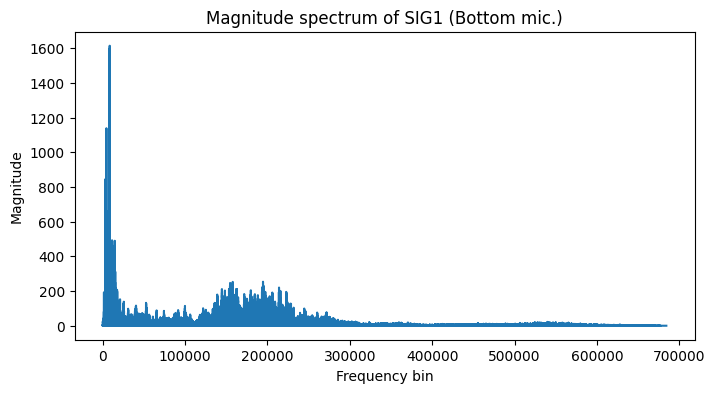

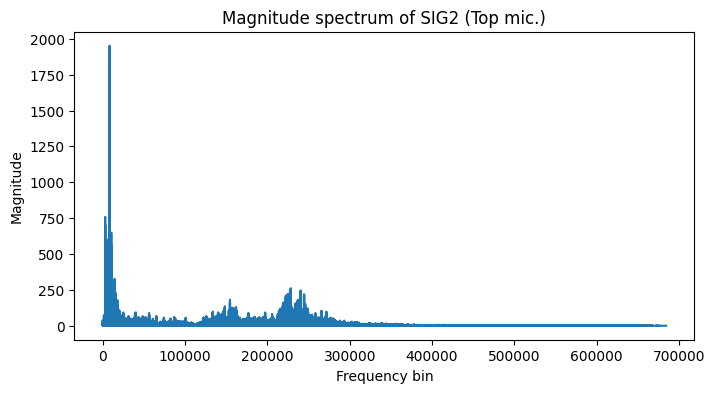

In [102]:
print(n) # N
print(sig1.shape)
print(sig2.shape)
print(SIG1.shape) # N/2+1 -> number of frequency bin
print(SIG2.shape) # N/2+1 -> number of frequency bin
print(R.shape)
print(cc.shape)
print(n//2)

# SIG1, SIG2 plot
plt.figure(figsize=(8,4))
plt.title("Magnitude spectrum of SIG1 (Bottom mic.)")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.plot(np.abs(SIG1))

plt.figure(figsize=(8,4))
plt.title("Magnitude spectrum of SIG2 (Top mic.)")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.plot(np.abs(SIG2))
plt.show()